<a href="https://colab.research.google.com/github/victorviro/Deep_learning_python/blob/master/Cifar_10_Image_classification_via_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In a previous [notebook](https://github.com/victorviro/Deep_learning_python/blob/master/Reusing_pretrained_layers_DNNs.ipynb) we explained why we should always try to find an existing neural network that accomplishes a similar task to the one we are trying to tackle and then reuse the lower layers of this network. This technique is called *transfer learning*.

In this notebook, we will show how to train an image classifier using pre-trained VGG16 on [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset.

In [1]:
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import applications
from tensorflow.keras import Input
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

## Loading data

Here we load data from [tensorflow_datasets](https://www.tensorflow.org/datasets) (hereafter TFDS). CIFAR-10 dataset is provided in TFDS as [cifar10](https://www.tensorflow.org/datasets/catalog/cifar10). The  CIFAR-10 dataset consists of 60000 32x32 color images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

By simply changing `dataset_name` below, we may also try this notebook for other datasets in TFDS such as [cifar100](https://www.tensorflow.org/datasets/catalog/cifar100), [stanford_dogs](https://www.tensorflow.org/datasets/catalog/stanford_dogs), [food101](https://www.tensorflow.org/datasets/catalog/food101), etc.


In [2]:
dataset_name = "cifar10"
(train, test), ds_info = tfds.load(
    dataset_name, split=["train", "test"], with_info=True, as_supervised=True
)
NUM_CLASSES = ds_info.features["label"].num_classes

In [3]:
print('Number of classes: {}'.format(NUM_CLASSES))
print('Number of images in training data: {}'.format(
    tf.data.experimental.cardinality(train).numpy()))
print('Number of images in test data: {}'.format(
    tf.data.experimental.cardinality(test).numpy()))

Number of classes: 10
Number of images in training data: 50000
Number of images in test data: 10000


## Visualizing the data
The following code shows the first 9 images with their labels.

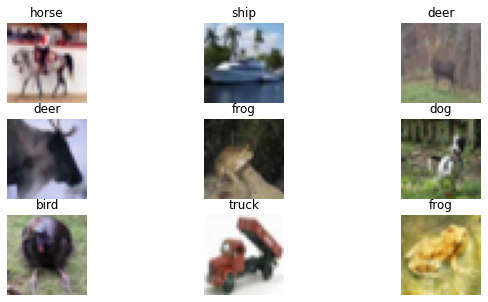

In [4]:
def format_label(label):
    string_label = label_info.int2str(label)
    return string_label

plt.figure(figsize=(10,5))
label_info = ds_info.features["label"]
for i, (image, label) in enumerate(train.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title("{}".format(format_label(label)))
    plt.axis("off")

## Data augmentation

We can use [preprocessing layers APIs](https://keras.io/guides/preprocessing_layers/) for image augmentation.

In [5]:
img_augmentation = Sequential(
    [
        preprocessing.RandomRotation(factor=0.15),
        preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
        preprocessing.RandomFlip(),
        preprocessing.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

This `Sequential` model object can be used both as a part of the model we later build, and as a function to preprocess data before feeding into the model. Using them as function makes it easy to visualize the augmented images. Here we plot 9 examples of augmentation result of a given figure.

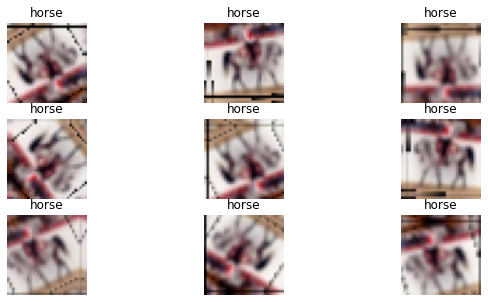

In [6]:
plt.figure(figsize=(10,5))
for image, label in train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        aug_img = img_augmentation(tf.expand_dims(image, axis=0))
        plt.imshow(aug_img[0].numpy().astype("uint8"))
        plt.title("{}".format(format_label(label)))
        plt.axis("off")

## Prepare inputs

Once we verify the input data and augmentation are working correctly, we prepare dataset for training. The labels are put into one-hot (categorical) encoding and the dataset is batched.

In [7]:
# One-hot / categorical encoding
def input_preprocess(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

BATCH_SIZE = 64 

ds_train = train.map(input_preprocess)
ds_train = ds_train.batch(batch_size=BATCH_SIZE, drop_remainder=True)


ds_test = test.map(input_preprocess)
ds_test = ds_test.batch(batch_size=BATCH_SIZE, drop_remainder=True)

In [8]:
for batch_x, batch_y in ds_train.take(5):
    print(batch_x.shape)
    print(batch_y.shape)

(64, 32, 32, 3)
(64, 10)
(64, 32, 32, 3)
(64, 10)
(64, 32, 32, 3)
(64, 10)
(64, 32, 32, 3)
(64, 10)
(64, 32, 32, 3)
(64, 10)


## Transfer learning from pre-trained weights

Here we initialize the model with pre-trained ImageNet weights, and we fine-tune it on our own dataset.

In [9]:
IMG_SIZE = 32

inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = img_augmentation(inputs)
# Load the VGG16 network, ensuring the head FC layer sets are left off
base_model = applications.VGG16(weights="imagenet", include_top=False,
                                input_tensor=x)

In [10]:
# Build the head of the model that will be placed on top of the base model
head_model = base_model.output
head_model = Flatten(name="flatten")(head_model)
head_model = Dense(512, activation="relu")(head_model)
head_model = Dropout(0.5)(head_model)
head_model = Dense(NUM_CLASSES, activation="softmax")(head_model)

# Place the head FC model on top of the base model
model = Model(inputs=inputs, outputs=head_model)

In [11]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
img_augmentation (Sequential (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)      

The first step to transfer learning is to freeze all layers and train only the top layers. For this step, a relatively large learning rate (`1e-2`) can be used.

The second step is to unfreeze a number of layers and fit the model using smaller learning rate. In this example we show unfreezing all layers, but depending on specific dataset it may be desireble to only unfreeze a fraction of all layers.

In [12]:
for layer in base_model.layers:
	layer.trainable = True
print(model.trainable)

True


A side note on freezing/unfreezing models: setting `trainable` of a `Model` will simultaneously set all layers belonging to the `Model` to the same `trainable` attribute. Each layer is trainable only if both the layer itself and the model containing it are trainable. Hence when we need to partially freeze/unfreeze a model, we need to make sure the `trainable` attribute of the model is set to `True`.

In [13]:
# Compile the model
opt = SGD(lr=1e-4, momentum=0.9)
model.compile(loss="categorical_crossentropy", optimizer=opt,
			  metrics=["accuracy"])

In [14]:
# Train the model
hist = model.fit(
	x=ds_train, 
    batch_size=BATCH_SIZE,
	validation_data=ds_test,
	epochs=30)

Epoch 1/30
  1/781 [..............................] - ETA: 0s - loss: 30.3744 - accuracy: 0.0781WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0161s vs `on_train_batch_end` time: 0.0246s). Check your callbacks.


781/781 [==============================] - 30s 39ms/step - loss: 2.3774 - accuracy: 0.0990 - val_loss: 2.3011 - val_accuracy: 0.0915
Epoch 2/30
781/781 [==============================] - 30s 38ms/step - loss: 2.2935 - accuracy: 0.1102 - val_loss: 2.2453 - val_accuracy: 0.1545
Epoch 3/30
781/781 [==============================] - 29s 38ms/step - loss: 2.2147 - accuracy: 0.1655 - val_loss: 2.1081 - val_accuracy: 0.1809
Epoch 4/30
781/781 [==============================] - 30s 38ms/step - loss: 2.0572 - accuracy: 0.2441 - val_loss: 1.9393 - val_accuracy: 0.3231
Epoch 5/30
781/781 [==============================] - 30s 38ms/step - loss: 1.8669 - accuracy: 0.3044 - val_loss: 1.6897 - val_accuracy: 0.4114
Epoch 6/30
781/781 [==============================] - 30s 39ms/step - loss: 1.6324 - accuracy: 0.4047 - val_loss: 1.3914 - val_accuracy: 0.5049
Epoch 7/30
781/781 [==============================] - 30s 39ms/step - loss: 1.4573 - accuracy: 0.4818 - val_loss: 1.2822 - val_accuracy: 0.5485
Epo

## Model evaluation

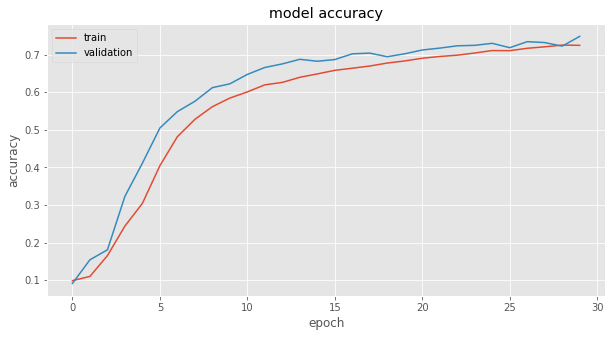

In [18]:
# Plotting the training and validation accuracy
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.style.use("ggplot")
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

plt.figure(figsize=(10,5))
plot_hist(hist)

## Predictions

In [16]:
predictions = model.predict(ds_test)

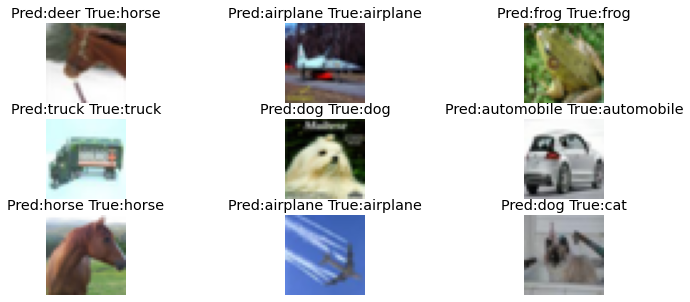

In [17]:
plt.figure(figsize=(10,5))
label_info = ds_info.features["label"]
for i, (image, label) in enumerate(test.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.subplots_adjust(wspace = 2)
    label_prediction = predictions.argmax(axis=1)[i]
    plt.title("Pred:{} True:{}".format(
        format_label(label_prediction),
        format_label(label)))
    plt.axis("off")

# References

- [Image classification via fine-tuning with EfficientNet](https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/)

- [Transfer learning & fine-tuning with Keras](https://keras.io/guides/transfer_learning/)

- [Fine-tuning with Keras](https://www.pyimagesearch.com/2019/06/03/fine-tuning-with-keras-and-deep-learning/)

- [Working with preprocessing layers](https://keras.io/guides/preprocessing_layers/)

- [Building powerful image classification models using very little data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)



